# Introduction

This notebook creates some charts to understand the structure of the PPO random data 

In [1]:
import GPy
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import re
import pymc3 as pm
import matplotlib.ticker as tk

In [4]:
df = pd.read_csv('results/all_results_average.csv')


In [5]:
df.head()

,id,basis,method,lag_time,n_components,n_clusters,fold_num,test_score,train_score
0,1,close_cont,bayesian,434.0,7,216,3,1.365817,2.961204
1,2,chi_tor,bayesian,61.5,8,719,3,1.102779,1.986818
2,3,alpha_angle,bayesian,264.0,9,503,3,1.599413,2.996799
3,4,all_tor,bayesian,454.5,6,245,3,1.921110,2.992483
4,5,close-h_cont,bayesian,114.0,10,990,3,1.665484,2.997487


In [95]:
# to_scale = ['n_components', 'n_clusters', 'lag_time']
# scaler = preprocessing.MinMaxScaler()
# vars_scaled = pd.DataFrame(scaler.fit_transform(df.loc[:, to_scale]), columns=[x+'_scaled' for x in to_scale])
# df = df.join(vars_scaled)

In [9]:
idx = (df['basis'] == 'ppo_tor') & ((df['method'] == 'random') | (df['method'] == 'sobol') )
df_ppo = df.loc[idx, :].rename(columns={'lag_time': 't', 'n_components': 'm', 'n_clusters': 'n', 'test_score': 'y'}).\
loc[:, ['y', 't', 'm', 'n']]
df_ppo.head()



,y,t,m,n
3978,1.594614,15.5,7,465
3979,1.863659,429.0,2,719
3980,1.898025,59.5,10,427
3981,1.761943,283.5,2,891
3982,1.381730,240.5,5,542


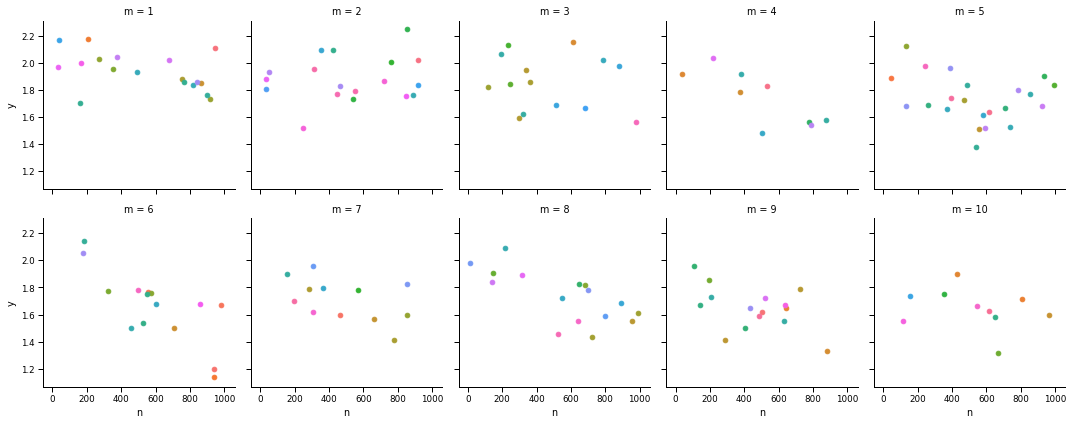

In [10]:
with sns.plotting_context('paper'):
    g = sns.FacetGrid(data=df_ppo, col='m', col_wrap=5, hue='t')
    g.map(plt.scatter, 'n', 'y')

In [117]:
X = X.rename(columns = {'n_components_scaled': 'm', 'n_clusters_scaled': 'n', 'lag_time_scaled': 't'} )

## Three variables - RBF Kernel

This is backwards! The number of inducing variables I got from visual inspection of the a chart in `bootstrap_gp_model.ipynb`. 

In [97]:
def fit_model(y, X, prop_Xu, l_prior, eta_prior, sigma_prior, n=500, n_chains=2):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    l/eta/sigma_prior : the prior for the various hyperparameters
    
    X, y are dataframes. We'll use the column names. 
    """
    
    with pm.Model() as model:
        
        # labels
        X_labs = ['l_'+ x[:5] for x in X.columns]
        y_lab = y.name
        
        # Covert arrays
        X = X.values
        y = y.values
        
        # Length priors
        length_priors = []
        for i in range(len(X_labs)):
            length_priors.append(l_prior(X_labs[i]))

        # covariance prior
        eta = eta_prior('eta')
        
        # Covariance function
        cov = eta**2
        for i in range(len(X_labs)):
            cov = cov*pm.gp.cov.ExpQuad(X.shape[1], ls=length_priors[i], active_dims=[i])

        # Sparse Model
        # Shift the mean function up to mean of response values. 
        # This is to increase speed of convergence. Could equally 
        # have shifted response to zero. 
        gp = pm.gp.MarginalSparse(pm.gp.mean.Constant(c=3), cov_func=cov, approx="FITC")
        
        # Noise model
        sigma_n = sigma_prior('sigma_n')
        
        # Inducing variables
        num_Xu = int(X.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X)
       
        # Marginal likelihood
        y_ = gp.marginal_likelihood(y_lab, X=X, y=y,Xu=Xu, noise=sigma_n)
        
        # Sample
        trace = pm.sample(draws=n, chains=n_chains, cores=1)
        
    return model, trace, gp

    

In [98]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


In [99]:
l_priors = [(1, 0.01), (1, 0.05), (1, 0.1)]
e_priors = [3, 2, 1]
s_priors = [3, 2, 1]

In [104]:
# model, trace, gp = fit_model(y=y, X=X, prop_Xu = 0.1, 
#                          l_prior=gamma(alpha=1, beta=1), 
#                          sigma_prior=hcauchy(beta=5), 
#                          eta_prior=hcauchy(beta=e_priors[1]), n=500, n_chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_n, eta, l_lag_t, l_n_clu, l_n_com]
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:18<00:00, 53.37it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|██████████| 500/500 [00:36<00:00, 13.65it/s]


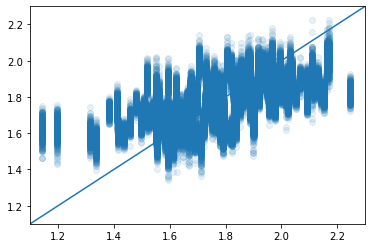

In [105]:
# with model:
#     n = 500
#     f_pred = gp.conditional("f_pred", X.values)
#     pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=n)
    
# plt.scatter( np.tile(y.values, n), pred_samples["f_pred"].flatten(), alpha=0.1)
# plt.xlim(1.1, 2.3)
# plt.ylim(1.1, 2.3)
# plt.plot(np.array([1.1, 2.3]),np.array([1.1, 2.3]))


In [106]:
X.rename

,n_components_scaled,n_clusters_scaled,lag_time_scaled
3978,0.666667,0.460141,0.030060
3979,0.111111,0.716448,0.858717
3980,1.000000,0.421796,0.118236
3981,0.111111,0.890010,0.567134
3982,0.444444,0.537841,0.480962


 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  0%|          | 0/5000 [00:00<?, ?it/s] /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
logp = 28.033, ||grad|| = 0.016702: 100%|██████████| 61/61 [00:00<00:00, 252.79it/s]  


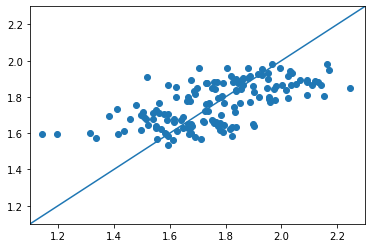

In [114]:
with pm.Model() as model:

    # labels
    X_labs = ['l_'+ x[:5] for x in X.columns]
    y_lab = y.name

    # Covert arrays
    X_a = X.values
    y_a = y.values
    
    # params
    prop_Xu = 0.1
    
    # covariance prior
    eta = pm.HalfCauchy('eta', beta=2)
    eta2 = pm.HalfCauchy('eta2', beta=2)

    # Covariance function
    cov = eta**2
    l_m = pm.Gamma('l_m', alpha=1, beta=0.05)
    l_n = pm.Gamma('l_n', alpha=1, beta=0.05)
    l_t = pm.Gamma('l_t', alpha=1, beta=0.05)

    l_m2 = pm.Gamma('l_m2', alpha=1, beta=0.05)
    l_n2 = pm.Gamma('l_n2', alpha=1, beta=0.05)
    
    cov = cov*pm.gp.cov.ExpQuad(X.shape[1], ls=l_m, active_dims=[0])
    cov = cov*pm.gp.cov.ExpQuad(X.shape[1], ls=l_n, active_dims=[1])
    cov = cov*pm.gp.cov.ExpQuad(X.shape[1], ls=l_t, active_dims=[2])

    cov2 = eta2**2*pm.gp.cov.ExpQuad(X.shape[1], ls=l_n2, active_dims=[1])
    cov2 = cov2*pm.gp.cov.ExpQuad(X.shape[1], ls=l_m2, active_dims=[0])

    cov_tot = cov+cov2
    
    # Sparse Model
    # Shift the mean function up to mean of response values. 
    # This is to increase speed of convergence. Could equally 
    # have shifted response to zero. 
    # pm.gp.mean.Constant(c=3),
    gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")

    # Noise model
    sigma_n = pm.HalfCauchy('sigma', beta=2)

    # Inducing variables
    num_Xu = int(X.shape[0]*prop_Xu)
    Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

    # Marginal likelihood
    y_ = gp.marginal_likelihood(y_lab, X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
    mp = pm.find_MAP()
    mu, var = gp.predict(X_a, point=mp, diag=True,pred_noise=False)
    sd = np.sqrt(var)
    
    plt.scatter(y_a, mu)
    lims = (1.1, 2.3)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims)
    # Sample
#     trace = pm.sample(draws=500, chains=1, cores=1)
    

In [122]:
dd = pt.dmatrix('t + C(m) + n', data=X, return_type='dataframe')

In [124]:
import re

In [129]:
dd = pt.dmatrix('t + C(m) + n', data=X, return_type='dataframe')
dd = dd.rename(columns=lambda x: re.sub('C|\\(|\\)|\\[|\\]','',x))
dd = dd.iloc[:, 1:dd.shape[1]]
dd

,mT.0.1111111111111111,mT.0.2222222222222222,mT.0.3333333333333333,mT.0.4444444444444445,mT.0.5555555555555556,mT.0.6666666666666665,mT.0.7777777777777777,mT.0.8888888888888888,mT.1.0,t,n
3978,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.030060,0.460141
3979,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.858717,0.716448
3980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.118236,0.421796
3981,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.567134,0.890010
3982,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.480962,0.537841
...,...,...,...,...,...,...,...,...,...,...,...
4122,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.222445,0.465187
4123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.750501,0.369324
4124,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.766533,0.131181
4125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172345,0.862765


In [ ]:
def prod_rbf(df, labs, prior):
    # Creates priors and 
    # product kernel
    n = df.shape[1]
    active_dims = 

In [141]:
m_labs = [x for x in dd.columns if x[0]=='m']
m_labs

['mT.0.1111111111111111',
 'mT.0.2222222222222222',
 'mT.0.3333333333333333',
 'mT.0.4444444444444445',
 'mT.0.5555555555555556',
 'mT.0.6666666666666665',
 'mT.0.7777777777777777',
 'mT.0.8888888888888888',
 'mT.1.0']

['l_mT.0.1', 'l_mT.0.2', 'l_mT.0.3', 'l_mT.0.4', 'l_mT.0.5', 'l_mT.0.6', 'l_mT.0.7', 'l_mT.0.8', 'l_mT.1.0', 'l_t', 'l_n']


 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  0%|          | 0/5000 [00:00<?, ?it/s] /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
logp = 1.2608, ||grad|| = 0.0015832: 100%|██████████| 61/61 [00:00<00:00, 170.54it/s]  


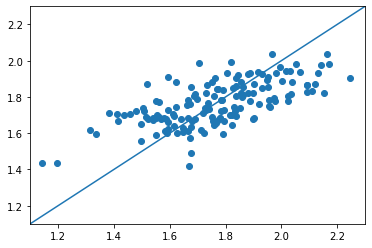

In [131]:
with pm.Model() as model:

    # labels
    X_labs = ['l_'+ x[:6] for x in dd.columns]
    print(X_labs)
    y_lab = y.name

    # Covert arrays
    X_a = dd.values
    y_a = y.values
    
    # params
    prop_Xu = 0.1
    l_prior = gamma(1, 0.05)
    eta_prior = hcauchy(2)
        
    
    # 3 way interaction
    length_priors = []
    for i in range(len(X_labs)):
        length_priors.append(l_prior(X_labs[i]))
    eta = eta_prior('eta')
    cov = eta**2
    for i in range(len(X_labs)):
        cov = cov*pm.gp.cov.ExpQuad(X.shape[1], ls=length_priors[i], active_dims=[i])

    
    
    # Sparse Model
    # Shift the mean function up to mean of response values. 
    # This is to increase speed of convergence. Could equally 
    # have shifted response to zero. 
    # pm.gp.mean.Constant(c=3),
    gp = pm.gp.MarginalSparse(pm.gp.mean.Constant(c=3), cov_func=cov_tot, approx="FITC")

    # Noise model
    sigma_n = pm.HalfCauchy('sigma', beta=2)

    # Inducing variables
    num_Xu = int(X_a.shape[0]*prop_Xu)
    Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

    # Marginal likelihood
    y_ = gp.marginal_likelihood(y_lab, X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
    mp = pm.find_MAP()
    mu, var = gp.predict(X_a, point=mp, diag=True,pred_noise=False)
    sd = np.sqrt(var)
    
    plt.scatter(y_a, mu)
    lims = (1.1, 2.3)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims)
    # Sample
#     trace = pm.sample(draws=500, chains=1, cores=1)
    

{'l_mT.0.1_log__': array(0.97359159),
 'l_mT.0.2_log__': array(2.2410132),
 'l_mT.0.3_log__': array(1.65538834),
 'l_mT.0.4_log__': array(1.60390857),
 'l_mT.0.5_log__': array(0.15100974),
 'l_mT.0.6_log__': array(1.47547298),
 'l_mT.0.7_log__': array(1.74673422),
 'l_mT.0.8_log__': array(1.06613355),
 'l_mT.1.0_log__': array(1.25230862),
 'l_t_log__': array(1.87115606),
 'l_n_log__': array(0.48996393),
 'eta_log__': array(-0.16645434),
 'sigma_log__': array(-1.85663074),
 'l_mT.0.1': array(2.6474359),
 'l_mT.0.2': array(9.40285344),
 'l_mT.0.3': array(5.23511255),
 'l_mT.0.4': array(4.9724296),
 'l_mT.0.5': array(1.16300799),
 'l_mT.0.6': array(4.37310367),
 'l_mT.0.7': array(5.73584006),
 'l_mT.0.8': array(2.90412911),
 'l_mT.1.0': array(3.49841014),
 'l_t': array(6.49580162),
 'l_n': array(1.63225735),
 'eta': array(0.84666148),
 'sigma': array(0.15619802)}